## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/My Drive/DetaSiens/SuperResolution/project/' 

## Import Libraries

In [ ]:
import numpy as np
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import cv2
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

from multiprocessing import Pool

from tqdm import tqdm
import glob
import pickle

## Load Images to Arrays

In [ ]:
train_images = glob.glob(path+'all_training/*.png') 
val_images = glob.glob(path+'all_testing/*.png') 


print('Number of training images:',len(train_images))
print('Number of validation images:',len(val_images))

Number of training images: 1000
Number of validation images: 200


In [ ]:
def read(path):
  img = image.load_img(path, target_size=(400,400,3))
  img = image.img_to_array(img)
  img = img/255.
  return img

# #p = Pool(1)
# p = Pool(10) #awalnya ini
# img_array = p.map(read, images)

In [ ]:
train_x = np.array([read(image) for image in tqdm(train_images)])

100%|██████████| 1000/1000 [10:17<00:00,  1.62it/s]


In [ ]:
val_x = np.array([read(image) for image in tqdm(val_images)])

100%|██████████| 200/200 [01:57<00:00,  1.70it/s]


In [ ]:
print('Training images shape:',train_x.shape)
print('Validation images shape:',val_x.shape)

Training images shape: (1000, 400, 400, 3)
Validation images shape: (200, 400, 400, 3)


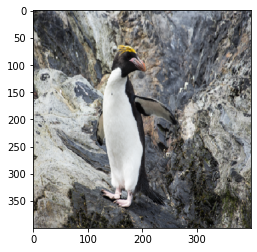

In [ ]:
plt.imshow(val_x[0])
plt.show()

## Pixelate Images (Distort)

In [ ]:
#now we will make input images by lowering resolution without changing the size
def pixelate_image(image, scale_percent = 60):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [ ]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixelate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixelate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [ ]:
print('Training images pixelated shape:',train_x_px.shape)
print('Validation images pixelated shape:',val_x_px.shape)

Training images pixelated shape: (1000, 400, 400, 3)
Validation images pixelated shape: (200, 400, 400, 3)


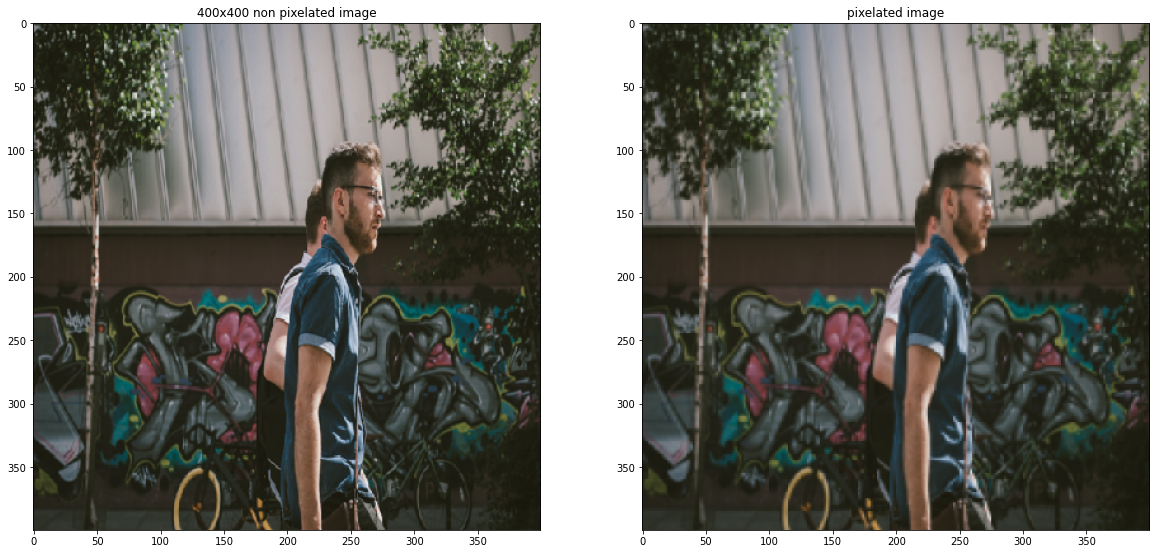

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title('400x400 non pixelated image')
plt.imshow(train_x[20])

plt.subplot(122)
plt.title('400x400 pixelated image')
plt.imshow(train_x_px[20])

plt.show()

## Model Architecture

 **Arsitektur EDSR Autoencoder Referensi**

 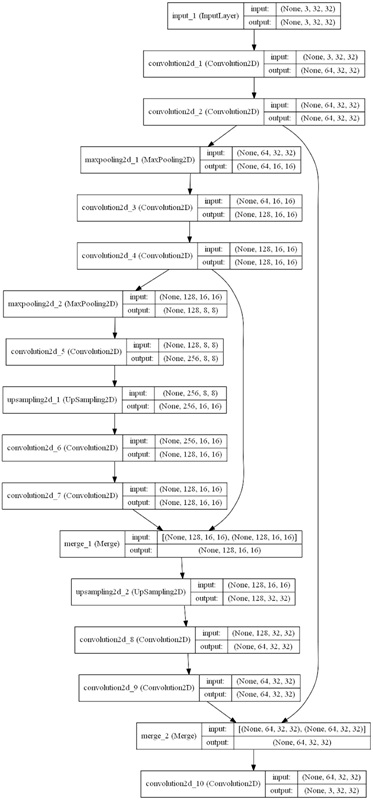

In [ ]:
Input_img = Input(shape=(400, 400, 3))  
    
#encoding architecture
l1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
print(l1.shape)
l2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(l1)
print(l2.shape)
m1 = MaxPool2D(padding='same')(l2)
print(m1.shape)

l3 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(m1)
print(l3.shape)

# encoded = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(l3)
# print(encoded.shape)

# decoding architecture
u1 = UpSampling2D()(l3)
print(u1.shape)
l4 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(u1)
print(l4.shape)
l5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(l4)
print(l5.shape)
r1 = Add()([l2, l5])
print(r1.shape)
m2 = MaxPool2D(padding='same')(r1)
print(m2.shape)

u2 = UpSampling2D()(m2)
print(u2.shape)
l6 = Conv2D(3, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(u2)
print(l6.shape)


# u2 = UpSampling2D()(r1)
# x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
# x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
# x14 = Add()([x2, x13])

# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
# decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(r1)
# print(decoded.shape)

autoencoder = Model(Input_img, l6)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

(None, 400, 400, 64)
(None, 400, 400, 32)
(None, 200, 200, 32)
(None, 200, 200, 12)
(None, 400, 400, 12)
(None, 400, 400, 32)
(None, 400, 400, 32)
(None, 400, 400, 32)
(None, 200, 200, 32)
(None, 400, 400, 32)
(None, 400, 400, 3)


In [ ]:
# #lets build the model No TPU
# #with strategy.scope():
# Input_img = Input(shape=(80, 80, 3))  
    
# #encoding architecture
# x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
# x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
# x3 = MaxPool2D(padding='same')(x2)

# x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
# x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
# x6 = MaxPool2D(padding='same')(x5)

# encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
# #encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# # decoding architecture
# x7 = UpSampling2D()(encoded)
# x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
# x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
# x10 = Add()([x5, x9])

# x11 = UpSampling2D()(x10)
# x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
# x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
# x14 = Add()([x2, x13])

# # x3 = UpSampling2D((2, 2))(x3)
# # x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# # x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
# decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

# autoencoder = Model(Input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Training The Model

In [ ]:
# autoencoder.summary()
# early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
# model_checkpoint = ModelCheckpoint(path+'model_edsr_400.h5',save_best_only=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 400, 400, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 400, 400, 32) 18464       conv2d_32[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 200, 200, 32) 0           conv2d_33[0][0]                  
____________________________________________________________________________________________

In [ ]:
# #Special dataset pipeline for running model on TPU
# def validation_input_fn(batch_size=1024):
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((val_x_px, val_x))
# # Shuffle, repeat, and batch the examples.
#     dataset = dataset.cache()
#     dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size, drop_remainder=True)
# # Return the dataset.
#     return dataset

In [ ]:
history = autoencoder.fit(train_x_px, train_x, epochs=1000, validation_data=(val_x_px, val_x), callbacks=[early_stopper, model_checkpoint])

Epoch 1/1000
32/32 [==============================] - 38s 898ms/step - loss: 0.0175 - accuracy: 0.6003 - val_loss: 0.0062 - val_accuracy: 0.7102
Epoch 2/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


32/32 [==============================] - 25s 792ms/step - loss: 0.0052 - accuracy: 0.7781 - val_loss: 0.0036 - val_accuracy: 0.8272
Epoch 3/1000
32/32 [==============================] - 25s 787ms/step - loss: 0.0032 - accuracy: 0.8514 - val_loss: 0.0028 - val_accuracy: 0.8595
Epoch 4/1000
32/32 [==============================] - 26s 799ms/step - loss: 0.0027 - accuracy: 0.8664 - val_loss: 0.0024 - val_accuracy: 0.8752
Epoch 5/1000
32/32 [==============================] - 26s 804ms/step - loss: 0.0023 - accuracy: 0.8800 - val_loss: 0.0021 - val_accuracy: 0.8766
Epoch 6/1000
32/32 [==============================] - 26s 802ms/step - loss: 0.0022 - accuracy: 0.8871 - val_loss: 0.0020 - val_accuracy: 0.8633
Epoch 7/1000
32/32 [==============================] - 26s 801ms/step - loss: 0.0021 - accuracy: 0.8809 - val_loss: 0.0019 - val_accuracy: 0.8841
Epoch 8/1000
32/32 [==============================] - 26s 799ms/step - loss: 0.0020 - accuracy: 0.8852 - val_loss: 0.0019 - val_accuracy: 0.891

## Load The Model

In [ ]:
autoencoder = tf.keras.models.load_model(path+'model_edsr_400.h5')

## Validation Images Prediction

In [ ]:
predictions = autoencoder.predict(val_x_px)

In [ ]:
n = 2
plt.figure(figsize= (20,30))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  ax.set_title("Distorted (Low Resolution) Image")
  plt.imshow(val_x_px[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  ax.set_title("Predicted Image")
  plt.imshow(predictions[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+(2*n))
  ax.set_title("Actual Image")
  plt.imshow(val_x[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

Output hidden; open in https://colab.research.google.com to view.